✅ 현재 코드 기준 정리

모델: RandomForestClassifier

목적: Recall 최적화 (GridSearch scoring="recall")

보정: CalibratedClassifierCV(sigmoid) → 확률값 보정

불균형 처리: SMOTE(train에만)

세그먼트 분석: KMeans(ChurnProbability vs MonthlyCharges)

👉 그래서 발표하실 때는 이렇게 정리하시면 딱 맞습니다:

"Churn 예측은 RandomForest 모델을 사용했습니다.
이탈 고객을 놓치지 않는 것이 중요하기 때문에 Recall을 최적화 기준으로 학습했고,
SMOTE를 통해 데이터 불균형 문제를 해결했습니다."

-Churn은 단순 공식으로 설명할 수 없고, 여러 요인이 얽혀 있는 확률적 문제라서 Residual 계산 대신 RandomForest/XGBoost 같은 분류 모델을 직접 학습하는 게 맞습니다. (왜 residual이 없냐면)

In [8]:
import pandas as pd
import numpy as np
import cloudpickle

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline


# ---------------------------
# 1. 데이터 불러오기
# ---------------------------
df = pd.read_csv("customer_Info copy.csv")
df = df.drop(columns=["customerID"])
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce").fillna(0)
df["Churn"] = df["Churn"].replace({"Yes": 1, "No": 0})

X = df.drop(columns=["Churn"])
y = df["Churn"]

numeric_features = ["tenure", "MonthlyCharges", "TotalCharges"]
categorical_features = [col for col in X.columns if col not in numeric_features]


# ---------------------------
# 2. 전처리 + 모델 파이프라인
# ---------------------------
def clean_numeric(X):
    X = X.copy()
    for col in ["TotalCharges", "MonthlyCharges", "tenure"]:
        X[col] = pd.to_numeric(X[col], errors="coerce").fillna(0)
    return X

numeric_cleaner = FunctionTransformer(clean_numeric)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

pipeline = Pipeline(steps=[
    ("cleaner", numeric_cleaner),
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("clf", RandomForestClassifier(random_state=42, class_weight="balanced"))
])


# ---------------------------
# 3. 하이퍼파라미터 튜닝
# ---------------------------
param_grid = {
    "clf__n_estimators": [200, 500],
    "clf__max_depth": [10, 20, None],
    "clf__min_samples_split": [2, 5],
    "clf__min_samples_leaf": [1, 2],
    "clf__max_features": ["sqrt", "log2"]
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring="recall",
    cv=skf,
    n_jobs=-1,
    verbose=2
)


# ---------------------------
# 4. 학습 & 보정
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

grid_search.fit(X_train, y_train)
print("최적 파라미터:", grid_search.best_params_)
print("최고 Recall:", grid_search.best_score_)

best_pipeline = grid_search.best_estimator_

calibrated_rfc = CalibratedClassifierCV(
    estimator=best_pipeline,
    method="sigmoid",
    cv=5
)
calibrated_rfc.fit(X_train, y_train)



# ---------------------------
# 5. Expected Loss 계산 (비즈니스 인사이트) ✅
# ---------------------------
# 1) 전체 데이터 예측 확률
df["churn_prob"] = calibrated_rfc.predict_proba(X)[:, 1]

# 2) 12개월 LTV 가정
df["LTV_12m"] = df["MonthlyCharges"] * 12

# 3) Expected Loss = churn_prob × LTV
df["expected_loss_12m"] = df["churn_prob"] * df["LTV_12m"]


# ---------------------------
# 6. 추가 세그먼트용 KMeans
# ---------------------------
y_prob = calibrated_rfc.predict_proba(X)[:, 1]

X_cluster = pd.DataFrame({
    "ChurnProbability": y_prob,
    "MonthlyCharges": X["MonthlyCharges"]
})

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
kmeans.fit(X_scaled)


# ---------------------------
# 6. 저장 (모델 + 스케일러 + 클러스터러)
# ---------------------------
bundle = {
    "model": calibrated_rfc,
    "scaler": scaler,
    "kmeans": kmeans
}

with open("pipeline_customer_churn_model.pkl", "wb") as f:
    cloudpickle.dump(bundle, f)

print("✅ 모델 + KMeans + Scaler 저장 완료")


C:\Users\honor\AppData\Local\Temp\ipykernel_21364\1701463331.py:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Churn"] = df["Churn"].replace({"Yes": 1, "No": 0})


Fitting 5 folds for each of 48 candidates, totalling 240 fits
최적 파라미터: {'clf__max_depth': 10, 'clf__max_features': 'log2', 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
최고 Recall: 0.6240802675585285
✅ 모델 + KMeans + Scaler 저장 완료


아래는 단순 시각화

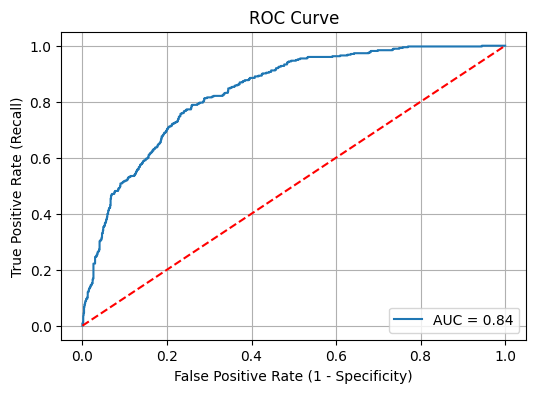

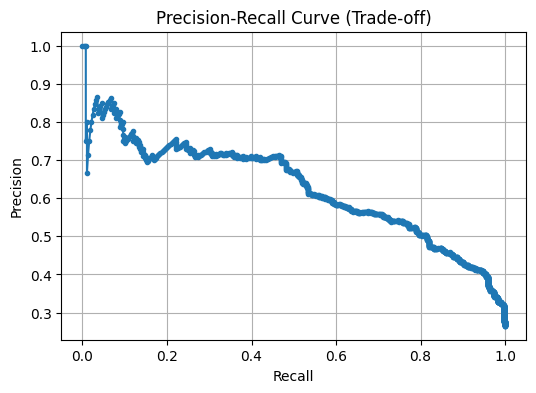

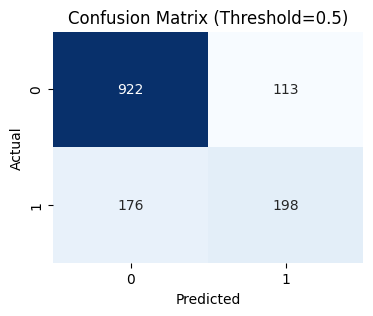

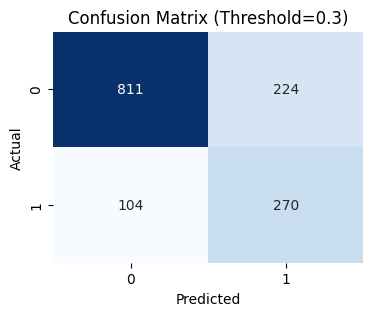

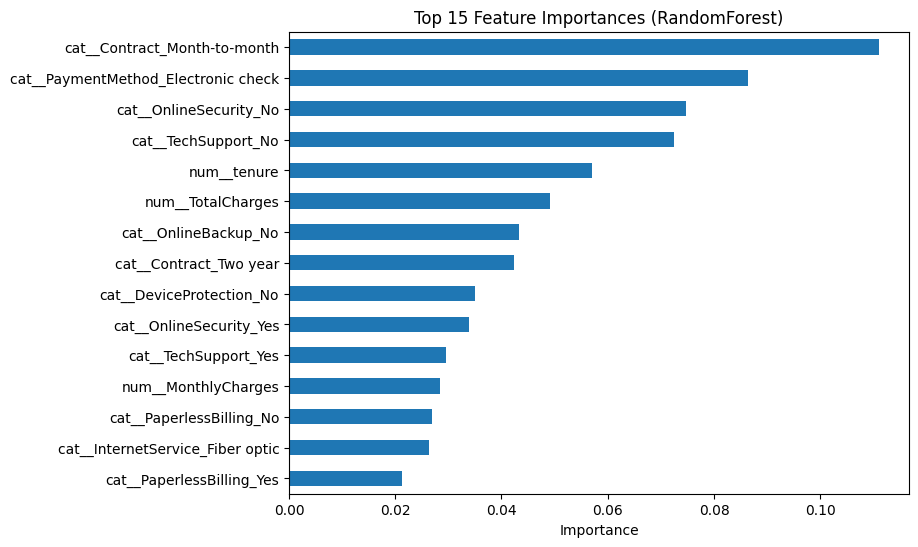

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, confusion_matrix
from sklearn.metrics import roc_curve, auc

# 예측 확률값
y_prob = calibrated_rfc.predict_proba(X_test)[:, 1]



# FPR, TPR 계산
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# 시각화
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1],[0,1],"r--")  # 랜덤 분류 기준선
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()




# ---------------------------
# 1. Precision-Recall Curve
# ---------------------------
y_prob = calibrated_rfc.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(6,4))
plt.plot(recalls, precisions, marker='.')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Trade-off)")
plt.grid(True)
plt.show()


# ---------------------------
# 2. Confusion Matrix (Threshold=0.5 vs 0.3)
# ---------------------------
for t in [0.5, 0.3]:
    y_pred = (y_prob >= t).astype(int)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix (Threshold={t})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


# ---------------------------
# 3. Feature Importance (RandomForest 기준)
# ---------------------------
# fit된 preprocessor 가져오기
fitted_preprocessor = best_pipeline.named_steps["preprocessor"]
feature_names = fitted_preprocessor.get_feature_names_out()

# RandomForest 모델 추출 (pipeline 안 clf)
rf_model = best_pipeline.named_steps["clf"]
importances = rf_model.feature_importances_

feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(15)

plt.figure(figsize=(8,6))
feat_imp.plot(kind="barh")
plt.title("Top 15 Feature Importances (RandomForest)")
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.show()